# Helpful score prediction

In [1]:
% matplotlib inline

import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_context("poster")
from operator import itemgetter

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import GradientBoostingClassifier

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

import string

from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag

from sklearn.base import BaseEstimator, TransformerMixin

/home/mangalam/anaconda2/envs/visual/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Load video games review dataframe

In [2]:
with open('pickle/video_games.pkl', 'rb') as input:
    video_games = pickle.load(input)

In [3]:
# Get only the reviews with a helpful rate
video_games = video_games[video_games.helpfulRate >= 0]
video_games = video_games[video_games.helpfulCount >= 10]

# Create a columns that will be use as a label for our binary classification
video_games['helpfulOrNot'] = video_games['helpfulRate'].apply(lambda x: 'helpful' if x > 0.5 else 'notHelpful')
video_games['helpfulOrNotOrNeutral'] = video_games.helpfulRate.map(lambda x: 'notHelpful' if x < 0.33 else 'neutral' if x < 0.66 else 'helpful')

video_games = video_games[video_games.helpfulOrNotOrNeutral != 'neutral']
# Add features
video_games['exclamationCount'] = video_games['reviewText'].str.count('!') + video_games['summary'].str.count('!')
video_games['questionCount'] = video_games['reviewText'].str.count('\?') + video_games['summary'].str.count('\?')
video_games['threeDotsCount'] = video_games['reviewText'].str.count('\.\.\.') + video_games['summary'].str.count('\.\.\.')
video_games['uppercaseCount'] = video_games['reviewText'].str.count('[A-Z]') + video_games['summary'].str.count('[A-Z]')


In [11]:
import collections
# Modified for python 3 from https://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/

class MeanEmbeddingVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    

class TfidfEmbeddingVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = collections.defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [12]:
w2v = dict(zip(w2v_model.wv.index2word, w2v_model.wv.syn0))
w2v_vectorizer = MeanEmbeddingVectorizer(w2v)


NameError: name 'w2v_model' is not defined

### Train w2v

In [13]:
# Modified for our need from http://migsena.com/build-and-visualize-word2vec-model-on-amazon-reviews/

raw_corpus = u"".join(video_games['reviewText']+" . " + video_games['summary'])

In [14]:
import nltk

# Load the punkt tokenizer
tokenizer = nltk.data.load("tokenizers/punkt/english.pickle")
print("The punkt tokenizer is loaded")
# we tokenize the raw string into raw sentences
raw_sentences = tokenizer.tokenize(raw_corpus)
print("We have {0:,} raw sentences".format(len(raw_sentences)))

The punkt tokenizer is loaded
We have 446,631 raw sentences


In [18]:
import re
from tqdm import tqdm
# Clean and split sentence into words
def clean_and_split_str(string):
    return NLTKPreprocessor().transform([string])[0]
     
# clean each raw sentences and build the list of sentences
sentences = []
i = 0
for raw_sent in tqdm(raw_sentences):
        sentences.append(clean_and_split_str(raw_sent))
print("We have {0:,} clean sentences".format(len(sentences)))

100%|██████████| 446631/446631 [22:37<00:00, 329.08it/s]

We have 446,631 clean sentences


In [19]:
import pickle
with open('pickle/sentences.pkl', "wb") as f:
    pickle.dump(sentences, f)

In [22]:
sentences = pickle.load(open('pickle/sentences.pkl', "rb"))

In [27]:
import multiprocessing
 
#Dimensionality of the resulting word vectors
num_features = 300
 
#Minimum word count threshold
min_word_count = 3
 
#Number of threads to run in parallel
num_workers = multiprocessing.cpu_count()
 
#Context window length
context_size = 7
 
#Seed for the RNG, to make the result reproducible
seed = 1


import gensim
 
word2vec_model = gensim.models.word2vec.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers, 
    size=num_features, 
    min_count=min_word_count, 
    window=context_size)
     
word2vec_model.build_vocab(sentences=sentences)
print("The vocabulary is built")
print("Word2Vec vocabulary length: ", len(word2vec_model.wv.vocab))
 
#Start training the model
%time word2vec_model.train(sentences=sentences, total_examples=word2vec_model.corpus_count, epochs=word2vec_model.iter)
print("Training finished")

The vocabulary is built
Word2Vec vocabulary length:  29839
CPU times: user 28min 36s, sys: 2.1 s, total: 28min 38s
Wall time: 2min 53s
Training finished


In [28]:
#Save the model
word2vec_model.save("w2v/video_games.w2v")
print("Model saved")

Model saved


In [29]:
# Load our word2vec model
import gensim
w2v_model = gensim.models.word2vec.Word2Vec.load("w2v/video_games.w2v")
print("Model loaded")

Model loaded


In [ ]:
count = len(w2v_model.wv.vocab)
word_vectors_matrix = np.ndarray(shape=(count, 300), dtype='float64')
word_list = []
i = 0
for word in w2v_model.wv.vocab:
    word_vectors_matrix[i] = w2v_model[word]
    word_list.append(word)
    i = i+1
    if i == count:
        break
print("word_vectors_matrix shape is ", word_vectors_matrix.shape)

In [ ]:
#Compress the word vectors into 2D space
import sklearn.manifold
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
word_vectors_matrix_2d = tsne.fit_transform(word_vectors_matrix)
print("word_vectors_matrix_2d shape is ", word_vectors_matrix_2d.shape)

In [82]:
word_vectors_matrix_2d.shape

(29839, 2)

In [81]:
#save these embeddins, ~30,000
with open('pickle/word_embeddings_tsne.pkl', "wb") as f:
    pickle.dump(word_vectors_matrix_2d, f)

In [83]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1]) 
        for word, coords in [
            (word, word_vectors_matrix_2d[word_list.index(word)])
            for word in word_list
        ]
    ],
    columns=["word", "x", "y"]
)
print("Points DataFrame built")

Points DataFrame built


,word,x,y
0,instal,-2.345660,36.847584
1,game,-19.063839,21.496477
2,struggle,25.083563,-2.532052
3,window,-25.219748,51.224083
4,live,-8.149001,37.782597
5,bug,11.736492,36.350281
6,championship,-34.167835,-9.449878
7,race,-39.621841,-14.460003
8,car,23.419203,-38.573006
9,unlocked,33.613602,-0.908708


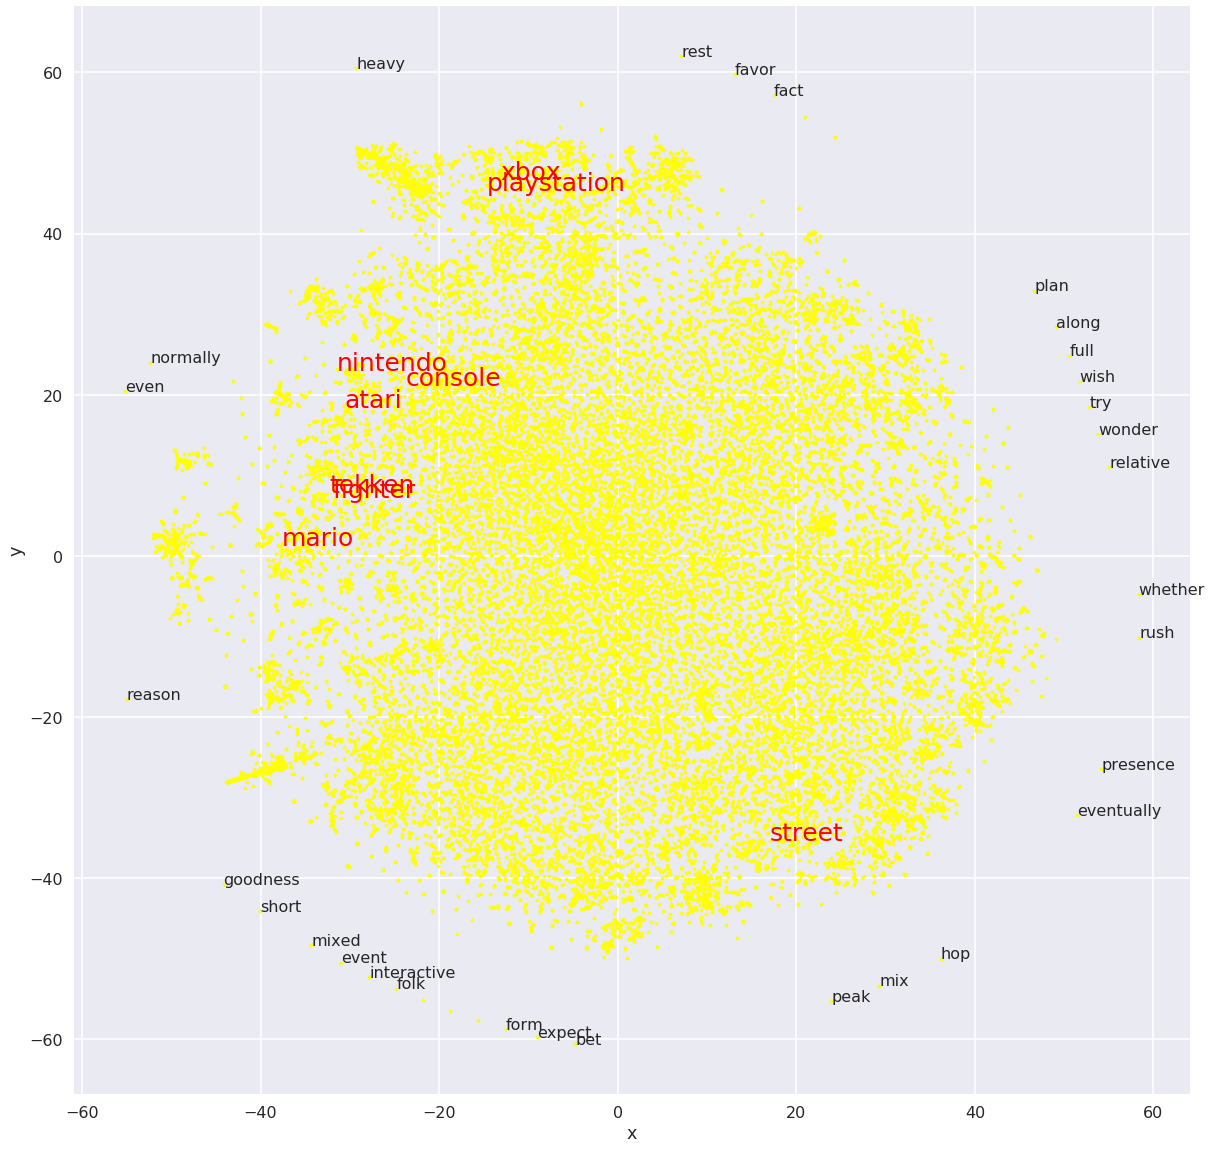

In [148]:
import random
def plot_region_outliers(x_weight , y_weight , thresh ):
    
    words_show = ['playstation','mario','nintendo','console','tekken','fighter','street','xbox','atari','nintendo']
    ax = points.plot.scatter("x", "y", s=10, figsize=(20, 20), color = 'yellow')
    for i,point in points.iterrows():
        if(point.word in words_show):
            ax.text(point.x + random.random()*5, point.y + random.random()*5, point.word, fontsize=25 , color = 'red')
        if(x_weight*point.x*point.x + y_weight*point.y*point.y >= thresh*thresh):
            ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=16)
 
plot_region_outliers(x_weight = 1, y_weight = 0.8, thresh = 54)

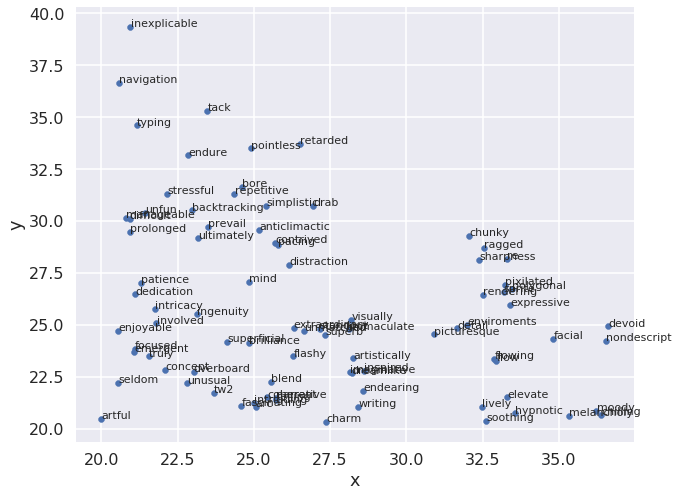

In [117]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) &
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1]) &
         (np.random.random((len(points.x),)) < 0.1)
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)
 
plot_region(x_bounds=(20, 40), y_bounds=(20, 40))

In [118]:
count = 500
word_vectors_matrix = np.ndarray(shape=(count, 300), dtype='float64')
word_list = []
i = 0
for word in w2v_model.wv.vocab:
    word_vectors_matrix[i] = w2v_model[word]
    word_list.append(word)
    i = i+1
    if i == count:
        break
print("word_vectors_matrix shape is ", word_vectors_matrix.shape)

word_vectors_matrix shape is  (500, 300)


In [119]:
tsne = sklearn.manifold.TSNE(n_components=3, random_state=0)
word_vectors_matrix_2d = tsne.fit_transform(word_vectors_matrix)
print("word_vectors_matrix_2d shape is ", word_vectors_matrix_2d.shape)

word_vectors_matrix_2d shape is  (500, 3)


In [120]:
points3D = pd.DataFrame(
    [
        (word, coords[0], coords[1],coords[2]) 
        for word, coords in [
            (word, word_vectors_matrix_2d[word_list.index(word)])
            for word in word_list
        ]
    ],
    columns=["word", "x", "y","z"]
)
print("3D Points DataFrame built")

3D Points DataFrame built


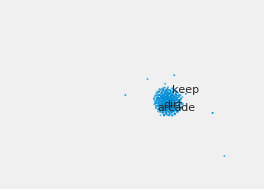

In [163]:
from matplotlib import style

style.use('fivethirtyeight')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y, Z = axes3d.get_test_data(0.05)
ax.scatter(list(points3D.x),list(points3D.y),list(points3D.z), zdir='x', s=2, c=None, depthshade=True,clip_on=True)
for i, point in points3D[:100].iterrows():
    if(random.random() < 0.02):
        ax.text(point.x + 0.005, point.y + 0.005, point.z + 0.005, point.word, fontsize=11)
plt.axis('off') # remove axes for visual appeal

angles = np.linspace(0,360,21)[:-1] # Take 20 angles between 0 and 360

ax.dist = 0.01
rotanimate(ax, angles,'movie.gif',delay=20) 
